## 🎯 Objetivo

Probar el modelo BETO entrenado para clasificar frases nuevas en las categorías retóricas:
ad_hominem, framing_binario, logos, retorica_vacia.

In [1]:
# === BLOQUE 0: Setup e importaciones ===
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# Ruta base del proyecto
PROJECT_ROOT = Path(r"D:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO")

# Carpeta del modelo entrenado
CKPT = PROJECT_ROOT / "models" / "beto_fold0_final"

# Etiquetas del modelo
id2label = {0:"ad_hominem", 1:"framing_binario", 2:"logos", 3:"retorica_vacia"}
label2id = {v:k for k,v in id2label.items()}

# Cargar modelo y tokenizer
tokenizer = AutoTokenizer.from_pretrained(CKPT)
model = AutoModelForSequenceClassification.from_pretrained(CKPT)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

print("✅ Modelo y tokenizer cargados desde:", CKPT)
print("Device:", device)


✅ Modelo y tokenizer cargados desde: D:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\models\beto_fold0_final
Device: cuda


In [2]:
# === BLOQUE 1: Función de clasificación de frases ===
def clasificar_frases(frases):
    inputs = tokenizer(frases, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
    resultados = [(f, id2label[p]) for f,p in zip(frases, preds)]
    return resultados


In [3]:
# === BLOQUE 2: Prueba rápida ===
frases = [
    "Ese político solo promete y nunca cumple.",
    "Ellos tuvieron su oportunidad, ahora nos toca a nosotros.",
    "Según los datos del INEI, la pobreza rural bajó un 5%.",
    "Perú será un país de esperanza y cambio."
]

predicciones = clasificar_frases(frases)
for texto, clase in predicciones:
    print(f"🗣️ '{texto}' → 🎯 {clase}")


🗣️ 'Ese político solo promete y nunca cumple.' → 🎯 ad_hominem
🗣️ 'Ellos tuvieron su oportunidad, ahora nos toca a nosotros.' → 🎯 framing_binario
🗣️ 'Según los datos del INEI, la pobreza rural bajó un 5%.' → 🎯 logos
🗣️ 'Perú será un país de esperanza y cambio.' → 🎯 retorica_vacia


In [4]:
# === BLOQUE 3A: UI con widgets (sin usar input) ===
from IPython.display import display, clear_output
import ipywidgets as w
import torch

ta = w.Textarea(
    value="Perú será un país de esperanza y cambio.",
    placeholder="Escribe aquí una frase política…",
    description="Frase:",
    layout=w.Layout(width="100%", height="80px")
)
btn = w.Button(description="Clasificar", button_style="primary")
out = w.Output()

def on_click(_):
    with out:
        clear_output()
        texto = ta.value.strip()
        if not texto:
            print("⚠️ Escribe una frase.")
            return
        inputs = tokenizer([texto], return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
        with torch.no_grad():
            pred = torch.argmax(model(**inputs).logits, dim=-1).item()
        print(f"→ {id2label[pred].upper()}")

btn.on_click(on_click)
display(ta, btn, out)


Textarea(value='Perú será un país de esperanza y cambio.', description='Frase:', layout=Layout(height='80px', …

Button(button_style='primary', description='Clasificar', style=ButtonStyle())

Output()

In [5]:
# Probabilidades por clase (softmax) y top-k
import torch, numpy as np
import torch.nn.functional as F

def proba_clases(texto, k=4):
    inputs = tokenizer([texto], return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = F.softmax(logits, dim=-1).cpu().numpy()[0]
    orden = np.argsort(-probs)[:k]
    return [(id2label[i], float(probs[i])) for i in orden]

# Ejemplo:
proba_clases("todos los de lima son los culpables")


[('retorica_vacia', 0.5058705806732178),
 ('ad_hominem', 0.43781277537345886),
 ('framing_binario', 0.04359722137451172),
 ('logos', 0.012719412334263325)]

In [6]:
%pip install unidecode


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
from unidecode import unidecode
print("ok")


ok


In [8]:
# Normalizador simple: minúsculas, tildes, espacios y corrección de typos comunes
import re
try:
    from unidecode import unidecode
except:
    !pip -q install unidecode
    from unidecode import unidecode

TYPO_MAP = {
    "cumpables": "culpables",
    "dubay": "dubái",  # ejemplo
}

def normalizar(txt: str) -> str:
    t = txt.strip().lower()
    t = unidecode(t)        # quita tildes
    t = re.sub(r"\s+", " ", t)
    for mal, bien in TYPO_MAP.items():
        t = t.replace(mal, bien)
    return t

def cls_norm(txt: str):
    t = normalizar(txt)
    inputs = tokenizer([t], return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        pred = torch.argmax(model(**inputs).logits, dim=-1).item()
    return id2label[pred]

# Prueba:
cls_norm("todos los fujimositas son los culpables")


'retorica_vacia'

In [9]:
# === BLOQUE 4: Clasificar lote de frases y exportar resultados ===
import pandas as pd

# Puedes reemplazar esta lista por frases reales de tu dataset o discursos nuevos
frases_test = [
    "Ese político solo promete y nunca cumple.",
    "Ellos tuvieron su oportunidad, ahora nos toca a nosotros.",
    "Según los datos del INEI, la pobreza rural bajó un 5%.",
    "Perú será un país de esperanza y cambio.",
    "Todos los de Lima son los culpables.",
    "El gobierno invertirá 200 millones en infraestructura rural."
]

# Normaliza, clasifica y almacena
registros = []
for f in frases_test:
    t = normalizar(f)
    inputs = tokenizer([t], return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        pred = torch.argmax(logits, dim=-1).item()
    registros.append({"texto": f, "prediccion": id2label[pred]})

df_resultados = pd.DataFrame(registros)

# Guardar archivo
RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(exist_ok=True)
out_path = RESULTS_DIR / "predicciones_inferencia.csv"
df_resultados.to_csv(out_path, index=False, encoding="utf-8")

print("✅ Resultados guardados en:", out_path)
display(df_resultados)


✅ Resultados guardados en: D:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\results\predicciones_inferencia.csv


,texto,prediccion
0,Ese político solo promete y nunca cumple.,ad_hominem
1,"Ellos tuvieron su oportunidad, ahora nos toca ...",framing_binario
2,"Según los datos del INEI, la pobreza rural baj...",logos
3,Perú será un país de esperanza y cambio.,retorica_vacia
4,Todos los de Lima son los culpables.,ad_hominem
5,El gobierno invertirá 200 millones en infraest...,logos


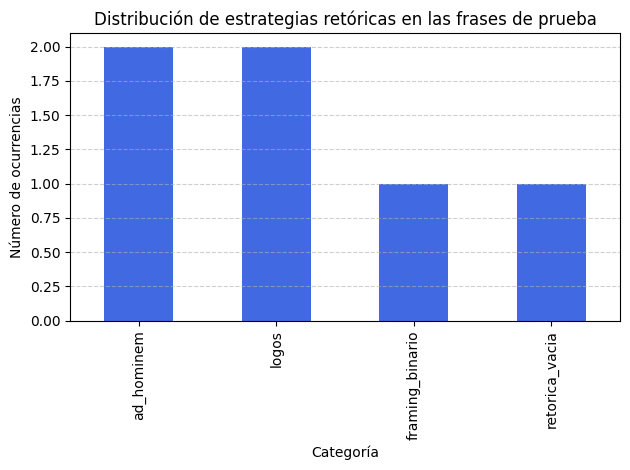

In [10]:
# === BLOQUE 5: Distribución de categorías clasificadas ===
import matplotlib.pyplot as plt

conteo = df_resultados["prediccion"].value_counts()
conteo.plot(kind="bar", color="royalblue")
plt.title("Distribución de estrategias retóricas en las frases de prueba")
plt.ylabel("Número de ocurrencias")
plt.xlabel("Categoría")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [11]:
# === BLOQUE 7 (opcional): exportar notebook con resultados ===
!jupyter nbconvert --to html 5_inferencia_beto.ipynb --output "inferencia_resultados.html"


## Clasificador híbrido (modelo + regla interpretable)

bloque híbrido para la demo: si la frase contiene patrones de culpabilización/colectivos y el modelo duda entre retorica_vacia y framing_binario, corrige a framing con una regla transparente.


In [12]:
# === BLOQUE 7: Clasificador híbrido para demo (modelo + regla) ===
import re, numpy as np, torch.nn.functional as F
KEYWORDS_FRAMING = [
    r"\bellos\b", r"\bnosotros\b", r"\blos de\b", r"\blas de\b",
    r"\blos limeñ", r"\blimeñ", r"\bculpable", r"\bculpables",
    r"\bresponsable", r"\bresponsables", r"\bellos son\b", r"\bno nosotros\b"
]

def es_framing_por_regla(texto_norm: str) -> bool:
    return any(re.search(pat, texto_norm) for pat in KEYWORDS_FRAMING)

def proba(texto_norm: str):
    inp = tokenizer([texto_norm], return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        logits = model(**inp).logits
        probs = F.softmax(logits, dim=-1).cpu().numpy()[0]
    return probs  # array de 4

def clasificar_hibrido(texto: str, thr_sec=0.35, max_gap=0.20):
    """
    Regla: si top1=retorica_vacia y top2=framing_binario y:
      - hay patrones de culpabilización/colectivos en el texto normalizado
      - PROB(top2) >= thr_sec y (PROB(top1)-PROB(top2)) <= max_gap
    entonces reasigna a framing_binario.
    """
    tnorm = normalizar(texto)
    probs = proba(tnorm)
    orden = np.argsort(-probs)
    top1, top2 = int(orden[0]), int(orden[1])
    label1, label2 = id2label[top1], id2label[top2]

    aplicado = False
    motivo = ""
    if label1 == "retorica_vacia" and label2 == "framing_binario":
        if es_framing_por_regla(tnorm) and (probs[top2] >= thr_sec) and ((probs[top1]-probs[top2]) <= max_gap):
            # Corrige a framing
            label1, aplicado = "framing_binario", True
            motivo = f"Regla aplicada (keywords + prob>= {thr_sec}, gap<= {max_gap})"

    detalle = {
        "top1": (id2label[int(orden[0])], float(probs[int(orden[0])])),
        "top2": (id2label[int(orden[1])], float(probs[int(orden[1])])),
        "top3": (id2label[int(orden[2])], float(probs[int(orden[2])])),
        "regla_aplicada": aplicado,
        "motivo": motivo
    }
    return label1, detalle


In [13]:
# === BLOQUE 7A: UI usando clasificar_hibrido ===
import ipywidgets as w
from IPython.display import display, clear_output

ta2 = w.Textarea(value="Todos los de Lima son los culpables.",
                 placeholder="Escribe aquí una frase política…",
                 description="Frase:", layout=w.Layout(width="100%", height="80px"))
btn2 = w.Button(description="Clasificar (híbrido)", button_style="primary")
out2 = w.Output()

def on_click_h(_):
    with out2:
        clear_output()
        texto = ta2.value.strip()
        if not texto:
            print("⚠️ Escribe una frase."); return
        label, det = clasificar_hibrido(texto)
        print("→", label.upper())
        print("\nTop-3 probabilidades:")
        for k in ["top1","top2","top3"]:
            print(f"  {det[k][0]:<16}: {det[k][1]:.3f}")
        if det["regla_aplicada"]:
            print("\n🛠️ Ajuste por regla:", det["motivo"])

display(ta2, btn2, out2)
btn2.on_click(on_click_h)


Textarea(value='Todos los de Lima son los culpables.', description='Frase:', layout=Layout(height='80px', widt…

Button(button_style='primary', description='Clasificar (híbrido)', style=ButtonStyle())

Output()

In [14]:
# === BLOQUE 7B: Lote con regla y comparación ===
import pandas as pd

frases_demo = [
    "Ese político solo promete y nunca cumple.",
    "Ellos tuvieron su oportunidad, ahora nos toca a nosotros.",
    "Según los datos del INEI, la pobreza rural bajó un 5%.",
    "Perú será un país de esperanza y cambio.",
    "Todos los de Lima son los culpables.",
    "Los limeños son responsables de la crisis.",
]

rows = []
for f in frases_demo:
    # predicción pura
    p0 = cls_norm(f)
    # híbrida
    ph, det = clasificar_hibrido(f)
    rows.append({
        "texto": f,
        "pred_base": p0,
        "pred_hibrida": ph,
        "top1": f"{det['top1'][0]} ({det['top1'][1]:.2f})",
        "top2": f"{det['top2'][0]} ({det['top2'][1]:.2f})",
        "regla": det["regla_aplicada"]
    })

df_cmp = pd.DataFrame(rows)
display(df_cmp)

# Guardar evidencia
(RESULTS_DIR / "demo_hibrida.csv").write_text(df_cmp.to_csv(index=False, encoding="utf-8"))
print("✅ Guardado:", RESULTS_DIR / "demo_hibrida.csv")


,texto,pred_base,pred_hibrida,top1,top2,regla
0,Ese político solo promete y nunca cumple.,ad_hominem,ad_hominem,ad_hominem (1.00),retorica_vacia (0.00),False
1,"Ellos tuvieron su oportunidad, ahora nos toca ...",framing_binario,framing_binario,framing_binario (0.99),retorica_vacia (0.00),False
2,"Según los datos del INEI, la pobreza rural baj...",logos,logos,logos (1.00),retorica_vacia (0.00),False
3,Perú será un país de esperanza y cambio.,retorica_vacia,retorica_vacia,retorica_vacia (1.00),logos (0.00),False
4,Todos los de Lima son los culpables.,ad_hominem,ad_hominem,ad_hominem (0.87),retorica_vacia (0.09),False
5,Los limeños son responsables de la crisis.,ad_hominem,ad_hominem,ad_hominem (0.78),framing_binario (0.10),False


✅ Guardado: D:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\results\demo_hibrida.csv


BLOQUE 8 para cerrar el Notebook 5: ajusta umbrales de la regla híbrida, re-evalúa tus frases, guarda los artefactos necesarios para el despliegue (config JSON + CSV final) y deja todo documentado.

In [15]:
# === BLOQUE 8: Cierre y preparación para despliegue (config + reevaluación) ===
from pathlib import Path
import json
import pandas as pd

# 1) Parámetros de la regla (ajústalos si quieres afinar la corrección)
thr_sec  = 0.30   # prob. mínima para la segunda clase (p.ej. framing_binario)
max_gap  = 0.30   # diferencia máxima entre top1 y top2 para permitir corrección

# 2) Reevaluar con los nuevos parámetros sobre un conjunto:
#    - Si existe df_resultados del Bloque 4, lo usamos (columna 'texto').
#    - Si no, usamos frases_demo (del Bloque 7B) o definimos una lista corta.
if 'df_resultados' in globals() and 'texto' in df_resultados.columns:
    frases_eval = df_resultados['texto'].tolist()
elif 'frases_demo' in globals():
    frases_eval = frases_demo
else:
    frases_eval = [
        "Ese político solo promete y nunca cumple.",
        "Ellos tuvieron su oportunidad, ahora nos toca a nosotros.",
        "Según los datos del INEI, la pobreza rural bajó un 5%.",
        "Perú será un país de esperanza y cambio.",
        "Todos los de Lima son los culpables.",
        "Los limeños son responsables de la crisis."
    ]

# Función auxiliar que aplica la versión híbrida con los umbrales elegidos
def clasificar_hibrido_con_params(texto, thr=0.35, gap=0.20):
    label, det = clasificar_hibrido(texto, thr_sec=thr, max_gap=gap)
    return label, det

# 3) Construir DataFrame comparativo (base vs híbrido con umbrales 8)
rows = []
for f in frases_eval:
    base = cls_norm(f)  # predicción "pura" con normalización
    hib, det = clasificar_hibrido_con_params(f, thr=thr_sec, gap=max_gap)
    rows.append({
        "texto": f,
        "pred_base": base,
        "pred_hibrida": hib,
        "top1": f"{det['top1'][0]} ({det['top1'][1]:.2f})",
        "top2": f"{det['top2'][0]} ({det['top2'][1]:.2f})",
        "regla_aplicada": det["regla_aplicada"]
    })

df_final = pd.DataFrame(rows)
display(df_final)

# 4) Métrica simple: cuántas predicciones cambió la regla
cambios = (df_final["pred_base"] != df_final["pred_hibrida"]).sum()
print(f"🔁 Cambios por la regla híbrida con thr_sec={thr_sec}, max_gap={max_gap}: {cambios} de {len(df_final)} frases.")

# 5) Guardar artefactos para despliegue
RESULTS_DIR = (PROJECT_ROOT / "results")
RESULTS_DIR.mkdir(exist_ok=True)

# 5.1) Config de inferencia (para web/API)
config = {
    "id2label": id2label,
    "label2id": label2id,
    "thr_sec": thr_sec,
    "max_gap": max_gap,
    "keywords_framing": KEYWORDS_FRAMING
}
with open(RESULTS_DIR / "inferencia_config.json", "w", encoding="utf-8") as f:
    json.dump(config, f, ensure_ascii=False, indent=2)

# 5.2) CSV final comparativo
csv_path = RESULTS_DIR / "inferencia_comparativa_final.csv"
df_final.to_csv(csv_path, index=False, encoding="utf-8")

print("✅ Artefactos guardados:")
print("   -", RESULTS_DIR / "inferencia_config.json")
print("   -", csv_path)

# 6) Nota para despliegue (recordatorio rápido)
print("""
👉 Despliegue web/API:
1) Cargar el checkpoint: models/beto_fold0_final/
2) Cargar tokenizer y modelo con Transformers (eval()).
3) Cargar 'results/inferencia_config.json' y aplicar:
   - normalizar(texto)
   - obtener softmax del modelo
   - aplicar regla híbrida con thr_sec y max_gap
4) Devolver predicción final + top-3 probabilidades (opcional para XAI).
""")


,texto,pred_base,pred_hibrida,top1,top2,regla_aplicada
0,Ese político solo promete y nunca cumple.,ad_hominem,ad_hominem,ad_hominem (1.00),retorica_vacia (0.00),False
1,"Ellos tuvieron su oportunidad, ahora nos toca ...",framing_binario,framing_binario,framing_binario (0.99),retorica_vacia (0.00),False
2,"Según los datos del INEI, la pobreza rural baj...",logos,logos,logos (1.00),retorica_vacia (0.00),False
3,Perú será un país de esperanza y cambio.,retorica_vacia,retorica_vacia,retorica_vacia (1.00),logos (0.00),False
4,Todos los de Lima son los culpables.,ad_hominem,ad_hominem,ad_hominem (0.87),retorica_vacia (0.09),False
5,El gobierno invertirá 200 millones en infraest...,logos,logos,logos (0.96),ad_hominem (0.02),False


🔁 Cambios por la regla híbrida con thr_sec=0.3, max_gap=0.3: 0 de 6 frases.
✅ Artefactos guardados:
   - D:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\results\inferencia_config.json
   - D:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\results\inferencia_comparativa_final.csv

👉 Despliegue web/API:
1) Cargar el checkpoint: models/beto_fold0_final/
2) Cargar tokenizer y modelo con Transformers (eval()).
3) Cargar 'results/inferencia_config.json' y aplicar:
   - normalizar(texto)
   - obtener softmax del modelo
   - aplicar regla híbrida con thr_sec y max_gap
4) Devolver predicción final + top-3 probabilidades (opcional para XAI).



5️⃣ Construir o cargar el hold-out humano
Opción A: lo construyes aquí mismo

Celda 6

( Probar con mas frases)

In [1]:
data_holdout = [
    ("Dice ser honesto, pero encubre a sus amigos", "ad_hominem"),
    ("Quieren destruir el país, nosotros vamos a rescatarlo", "framing_binario"),
    ("El 40% de los jóvenes perdió su empleo el último año", "logos"),
    ("Promete cambio, pero no explica cómo lo hará", "retorica_vacia"),
    # agrega aquí muchas más frases creadas por ti...
]

df_holdout = pd.DataFrame(data_holdout, columns=["text", "label_name"])
df_holdout["label"] = df_holdout["label_name"].map(label2id)

HOLDOUT_PATH = "../data/holdout_humano.csv"
df_holdout.to_csv(HOLDOUT_PATH, index=False, encoding="utf-8")
df_holdout.head()


NameError: name 'pd' is not defined